# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
from octopuslite import utils, tile
import btrack

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


In [3]:
metadata

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [4]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
assay_layout = utils.read_harmony_metadata(metadata_path, assay_layout=True, mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...


/home/dayn/analysis/octopuslite-reader/octopuslite/utils.py:325: FutureWarning: The default value of regex will change from True to False in a future version.
  corresponding_mask_fns = input_img_fns.str.replace('ch(\d+)', 'ch99')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


Extracting metadata complete!


Strain Compound Concentration ConcentrationEC  \
3 4    RD1     CTRL             0             EC0   
  5     WT     CTRL             0             EC0   
  6     WT      PZA            60            EC50   
  7     WT      RIF           0.1            EC50   
  8     WT      INH          0.04            EC50   
  9     WT      BDQ          0.02            EC50   
4 4    RD1     CTRL             0             EC0   
  5     WT     CTRL             0             EC0   
  6     WT      PZA            60            EC50   
  7     WT      RIF           0.1            EC50   
  8     WT      INH          0.04            EC50   
  9     WT      BDQ          0.02            EC50   
5 4    RD1     CTRL             0             EC0   
  5     WT     CTRL             0             EC0   
  6     WT      PZA           400            EC99   
  7     WT      RIF             2            EC99   
  8     WT      INH             2            EC99   
  9     WT      BDQ           2.5            EC99   
6 4    RD1     CTRL             0             EC0   
  5     WT     CTRL             0             EC0   
  6     WT      PZA           400            EC99   
  7     WT      RIF             2            EC99   
  8     WT      INH             2            EC99   
  9     WT      BDQ           2.5            EC99   

                                         Missing masks  
3 4                                               None  
  5  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  6  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  7                                               None  
  8  (1098, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  9  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
4 4  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  5  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  6                                               None  
  7  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  8  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  9                                               None  
5 4                                               None  
  5                                               None  
  6  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  7  (225, [/mnt/DATA/sandbox/pierre_live_cell_data...  
  8                                               None  
  9  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
6 4  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  5  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  6                                               None  
  7  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  8  (2025, [/mnt/DATA/sandbox/pierre_live_cell_dat...  
  9                                               None

### Define row and column of choice

In [5]:
row = '5'
column = '4'

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [6]:
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
                             set_time = 1,
#                             input_transforms = [input_transforms]
                            ).compute().compute()

In [9]:
%%time
images = tile.compile_mosaic(image_dir, metadata, row, column, set_plane=1,)#tile.compile_mosaic(image_dir, metadata, row, column,).compute().compute()
images

CPU times: user 153 ms, sys: 0 ns, total: 153 ms
Wall time: 150 ms


,Array,Chunk
Bytes,10.22 GiB,15.50 MiB
Shape,"(75, 2, 1, 6048, 6048)","(1, 2, 1, 2016, 2016)"
Count,5850 Tasks,675 Chunks
Type,uint16,numpy.ndarray


# Load tracks

In [29]:
with btrack.dataio.HDF5FileHandler("/mnt/DATA/macrohet/segmentation/[('5', '4')]_tracks.h5", 'r') as hdf:
    tracks = hdf.tracks
data, properties, graph = btrack.utils.tracks_to_napari(tracks)

[INFO][2023/01/25 05:11:34 pm] Opening HDF file: /mnt/DATA/macrohet/segmentation/[('5', '4')]_tracks.h5...
25-Jan-23 17:11:34 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/segmentation/[('5', '4')]_tracks.h5...
[INFO][2023/01/25 05:11:34 pm] Loading tracks/obj_type_1
25-Jan-23 17:11:34 - btrack.dataio - INFO     - Loading tracks/obj_type_1
[INFO][2023/01/25 05:11:34 pm] Loading LBEP/obj_type_1
25-Jan-23 17:11:34 - btrack.dataio - INFO     - Loading LBEP/obj_type_1
[INFO][2023/01/25 05:11:34 pm] Loading objects/obj_type_1 (27397, 5) (27397 filtered: None)
25-Jan-23 17:11:34 - btrack.dataio - INFO     - Loading objects/obj_type_1 (27397, 5) (27397 filtered: None)
[INFO][2023/01/25 05:11:35 pm] Closing HDF file: /mnt/DATA/macrohet/segmentation/[('5', '4')]_tracks.h5
25-Jan-23 17:11:35 - btrack.dataio - INFO     - Closing HDF file: /mnt/DATA/macrohet/segmentation/[('5', '4')]_tracks.h5


In [46]:
with btrack.dataio.HDF5FileHandler("/mnt/DATA/macrohet/segmentation/[(5, 4)]_tracks.h5", 'r') as hdf:
    tracks = hdf.tracks
    obj = hdf.objects
#     masks = hdf.segmentation
data, properties, graph = btrack.utils.tracks_to_napari(tracks)

[INFO][2023/01/25 05:18:23 pm] Opening HDF file: /mnt/DATA/macrohet/segmentation/[(5, 4)]_tracks.h5...
25-Jan-23 17:18:23 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/segmentation/[(5, 4)]_tracks.h5...
[INFO][2023/01/25 05:18:23 pm] Loading tracks/obj_type_1
25-Jan-23 17:18:23 - btrack.dataio - INFO     - Loading tracks/obj_type_1
[INFO][2023/01/25 05:18:23 pm] Loading LBEP/obj_type_1
25-Jan-23 17:18:23 - btrack.dataio - INFO     - Loading LBEP/obj_type_1
[INFO][2023/01/25 05:18:23 pm] Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
25-Jan-23 17:18:23 - btrack.dataio - INFO     - Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
[INFO][2023/01/25 05:18:24 pm] Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
25-Jan-23 17:18:24 - btrack.dataio - INFO     - Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
[ERROR][2023/01/25 05:18:24 pm] Segmentation not found in /mnt/DATA/macrohet/segmentation/[(5, 4)]_tracks.h5
25-Jan-2

In [47]:
with btrack.dataio.HDF5FileHandler("/mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5", 'r') as hdf:
    masks = hdf.segmentation

[INFO][2023/01/25 05:19:12 pm] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5...
25-Jan-23 17:19:12 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5...
[INFO][2023/01/25 05:19:12 pm] Loading segmentation (75, 1200, 1200)
25-Jan-23 17:19:12 - btrack.dataio - INFO     - Loading segmentation (75, 1200, 1200)
[INFO][2023/01/25 05:19:12 pm] Closing HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5
25-Jan-23 17:19:12 - btrack.dataio - INFO     - Closing HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5


In [49]:
masks.shape

(75, 1200, 1200)

In [37]:
tracks[100]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-0,orientation,mean_intensity-1,area,minor_axis_length,major_axis_length
0,229,0,923.656677,294.141998,0.000000,229,229,5,0,False,1.307837e-16,-1.410981,2.049400e-17,1500.0,27.523493,69.723518
1,229,1,926.849304,293.858551,0.000000,229,229,5,0,False,1.221123e-16,-1.397895,2.044588e-17,1725.0,28.170187,78.488129
2,229,2,929.567078,294.180573,0.000000,229,229,5,0,False,1.120681e-16,-1.412195,2.036192e-17,1894.0,29.861010,81.315819
3,229,3,930.227051,293.352478,0.000000,229,229,5,0,False,1.103674e-16,-1.453431,2.033683e-17,1810.0,29.432484,78.695099
4,229,4,933.388794,294.734222,0.000000,229,229,5,0,False,1.085864e-16,-1.441000,2.035841e-17,1821.0,31.250368,75.295525
5,229,5,932.911316,294.406738,0.000000,229,229,5,0,False,1.050167e-16,-1.432723,2.030602e-17,1962.0,30.718018,82.427864
6,229,6,928.093445,295.158051,0.000000,229,229,5,0,False,9.619105e-17,-1.494108,2.020184e-17,2183.0,30.626591,91.950340
7,229,7,924.690308,294.853729,0.000000,229,229,5,0,False,1.002645e-16,-1.522018,2.020082e-17,2099.0,28.037977,99.617050
8,229,8,921.030212,294.931152,0.000000,229,229,5,0,False,1.076351e-16,-1.550842,2.023716e-17,2019.0,26.892298,102.273483
9,229,9,914.339966,292.720093,0.000000,229,229,5,0,False,1.046319e-16,1.519962,2.016489e-17,2165.0,25.712690,118.580780


# Launch napari image viewer

In [23]:
images

,Array,Chunk
Bytes,40.88 GiB,62.02 MiB
Shape,"(75, 2, 6048, 6048)","(1, 2, 2016, 2016)"
Count,16200 Tasks,675 Chunks
Type,uint64,numpy.ndarray


In [51]:
tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-0,orientation,mean_intensity-1,area,minor_axis_length,major_axis_length
0,266,0,951.343323,45.812744,0.0,266,266,5,0,False,2.041095e-16,-0.158410,2.155834e-17,769.0,26.891737,36.497147
1,266,1,954.995667,46.476086,0.0,266,266,5,0,False,1.929794e-16,-0.373139,2.140554e-17,920.0,26.052063,45.582153
2,266,2,957.353577,48.257397,0.0,266,266,5,0,False,1.543625e-16,-0.195424,2.079401e-17,1352.0,34.261978,53.053318
3,266,3,959.365356,58.992851,0.0,266,266,5,0,False,1.671562e-16,-0.502970,2.091538e-17,1259.0,33.654800,49.256756
4,266,4,952.433167,68.036667,0.0,266,266,5,0,False,1.608859e-16,-0.552988,2.114259e-17,1309.0,25.973265,67.137032
5,266,5,957.532471,60.255157,0.0,266,266,5,0,False,1.615201e-16,-0.409017,2.095080e-17,1309.0,27.933081,63.076984
6,266,6,956.719604,66.276291,0.0,266,266,5,0,False,1.817476e-16,-0.294665,2.148875e-17,970.0,24.457964,50.998814


In [7]:
from skimage.io import imread

In [15]:
control = imread('/home/dayn/Pictures/thesis/control_ras.png')

In [16]:
control.shape

(754, 701, 4)

In [32]:
r = control[...,0]
g = control[...,1]
b = control[...,2]
a = control[...,3]

In [17]:
15*12

180

754 pixels is 180 microns so 

In [18]:
180/754

0.23872679045092837

In [30]:
scale = [(180/754)*1.25, (180/754)*1.25]
scale

[0.2984084880636605, 0.2984084880636605]

In [34]:
text_size = 24

In [40]:
viewer = napari.Viewer()
viewer.add_image(r, scale=scale,  contrast_limits=[49,255], colormap='magenta')
viewer.add_image(g, scale=scale, colormap='green')
# viewer.add_image(b, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'
viewer.scale_bar.font_size = text_size
viewer.scale_bar.position = 'top_right'

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [38]:
help(viewer.scale_bar)

Help on ScaleBar in module napari.components.scale_bar object:

class ScaleBar(napari.utils.events.evented_model.EventedModel)
 |  ScaleBar(*, visible: bool = False, colored: bool = False, color: napari.utils.color.ColorValue = [1, 0, 1, 1], ticks: bool = True, position: napari.components._viewer_constants.Position = <Position.BOTTOM_RIGHT: 'bottom_right'>, font_size: float = 10, box: bool = False, box_color: napari.utils.color.ColorValue = [0, 0, 0, 0.6], unit: Optional[str] = None) -> None
 |  
 |  Scale bar indicating size in world coordinates.
 |  
 |  Attributes
 |  ----------
 |  visible : bool
 |      If scale bar is visible or not.
 |  colored : bool
 |      If scale bar are colored or not. If colored then
 |      default color is magenta. If not colored than
 |      scale bar color is the opposite of the canvas
 |      background or the background box.
 |  color : ColorValue
 |      Scalebar and text color.
 |      See ``ColorValue.validate`` for supported values.
 |  ticks : 

In [31]:
viewer = napari.Viewer()
viewer.add_image(control, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'
viewer.scale_bar.font_size = text_size

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [46]:
from skimage import transform
from skimage.io import imshow
import cv2
import numpy as np

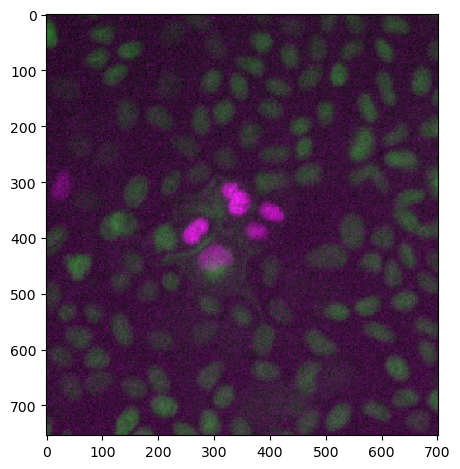

In [42]:
imshow(control)

In [44]:
img = control

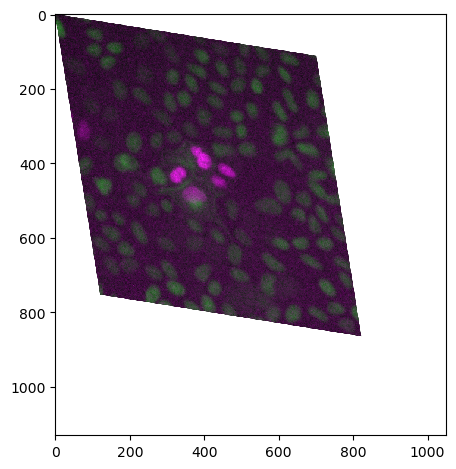

In [60]:
rows, cols, dim = img.shape
# transformation matrix for Shearing
# shearing applied to x-axis
M = np.float32([[1, 0.16, 0],
             	[0.16, 1  , 0],
            	[0, 0  , 1]])
# shearing applied to y-axis
# M = np.float32([[1,   0, 0],
#             	  [0.5, 1, 0],
#             	  [0,   0, 1]])
# apply a perspective transformation to the image                
sheared_img = cv2.warpPerspective(img,M,(int(cols*1.5),int(rows*1.5)))
imshow(sheared_img)

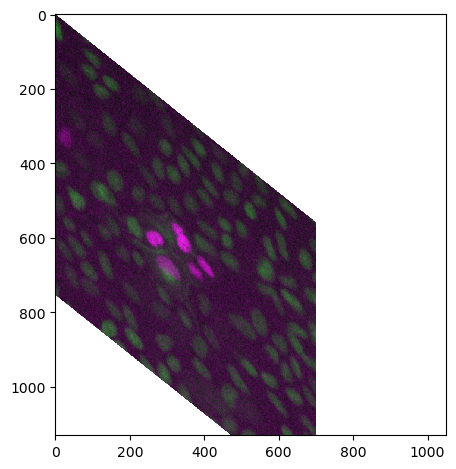

In [73]:
graph = imread('/home/dayn/Pictures/Screenshot from 2023-01-26 18-06-58.png')

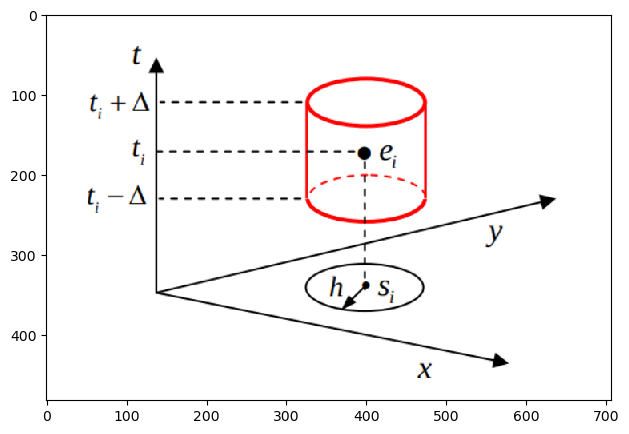

In [76]:
imshow(graph)

In [75]:
graph

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

In [70]:
x = list() # np.zeros((482, 706))
for i in range(4):
    x.append(graph[...,i])
    

In [77]:
v = napari.Viewer()
v.add_image(graph, channel_axis=-1)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


[<Image layer 'Image' at 0x7fcb4515f340>,
 <Image layer 'Image [1]' at 0x7fcb460dcf40>,
 <Image layer 'Image [2]' at 0x7fcb463dffd0>,
 <Image layer 'Image [3]' at 0x7fcb466c7e50>]